# Loading Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import zipfile
import os, os.path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Defining path to access each class folder
Path = '/content/drive/My Drive/Raw_Data' ## put the Raw_Data folder in your Drive
subdir_list = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

#Function to count the number of images
def count_images(directory):
    return len([name for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name)) and
                name.lower().endswith(('.png', '.jpg', '.jpeg'))])

#Loop through each class, print number of images and total number of images
tot_images = 0
for subfolder in subdir_list:
    subfolder_path = os.path.join(Path, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = count_images(subfolder_path)
        tot_images += num_images
        print(f"Number of images in '{subfolder}': {num_images}")
print(f"Total number of images: {tot_images}")

Number of images in 'glioma_tumor': 2547
Number of images in 'meningioma_tumor': 2582
Number of images in 'no_tumor': 2396
Number of images in 'pituitary_tumor': 2658
Total number of images: 10183


The distribution of images in each class is fairly even/uniform; with each class containing between ~2400 - ~2650 images each. A fairly even class distribution will prevent the model from unfairly "memorizing/predicting" one class.

# Data Splitting

Using splitfolders which will split (via random sampling) a folder containing data into a test,validation and training dataset. The team will be using a 60-20-20 %, training - validation - test split.

In [ ]:
!pip install split_folders

In [ ]:
import splitfolders
splitfolders.ratio(Path, '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split',seed=999, ratio=(.6,.2,.2))

Copying files: 10183 files [44:27,  3.82 files/s]


In [ ]:
split_list = ['train', 'val', 'test']
subdir_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split'

tot_images = 0
for split in split_list:
    split_path = os.path.join(subdir_path, split)
    if os.path.isdir(split_path):
        print(f"{split} set image distribution:")
        for class_folder in subdir_list:
            class_folder_path = os.path.join(split_path, class_folder)
            if os.path.isdir(class_folder_path):
                num_images = count_images(class_folder_path)
                tot_images += num_images
                print(f"  Number of images in class '{class_folder}': {num_images}")
print(f"Total number of images: {tot_images}")

Total number of images: 0


# Data Cleaning and Augmentation

Cleaning - transforming images into tensors, resizing them into 224 by 224 and Normalizing.

Augmentation - applying random rotations, adding noise and changing color intensity

#### Looking at an example image first

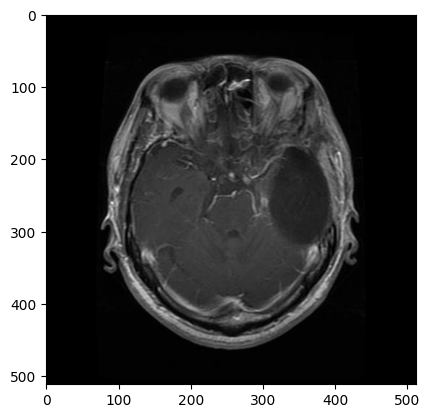

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import urllib

# loading an image
path = "/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/test/glioma_tumor/Te-gl_0015.jpg"
img = plt.imread(path)
plt.imshow(img)

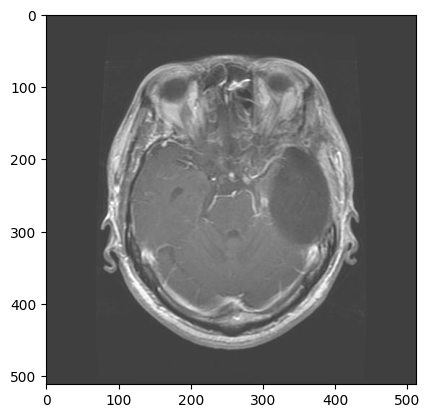

In [ ]:
# applying a discoloring effect
img = img/255
img_changed = np.clip((img + 0.25), 0, 1)
plt.imshow(img_changed)

In [ ]:
import torch

#convert to tensor
x = torch.from_numpy(img)
print(x.shape)

# move the channel dimension to the beginning
x = x.permute(2,0,1)
print(x.shape)

torch.Size([512, 512, 3])
torch.Size([3, 512, 512])


Therefore, each image has 3 color channels and has a size of 512 by 512 pixels. Each image also has color intensities ranging from 0 to 255.

#### Changing images to grayscale (1 color channel), 224 by 224 pixels, normalizing color intensities and applying augmentations


In [ ]:
# randomly changing color intensity in each image by a constant value

folder_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/train'

for Class in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
  class_path = os.path.join(folder_path, Class)

  # List contents of the folder
  contents = os.listdir(class_path)

  for img_name in contents:
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    random_num = np.random.randint(0,1)
    if(random_num < 0.5):
      img = img/255
      img = np.clip((img + 0.25), 0, 1)


NameError: name 'os' is not defined

In [ ]:
def create_loaders(batch_size):

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5), (0.5))
                                    ])

    augment = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.RandomRotation(45, fill = 0),
                                    transforms.GaussianBlur(5, (0.1,2)),
                                    transforms.Normalize((0.5), (0.5))
                                    ])



    #Create Datasets for each set and apply transformation to training dataset
    train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/train', transform=augment, num_workers = 4, pin_memory = True)
    val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/val', transform = transform,num_workers = 4, pin_memory = True)
    test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/test', transform = transform,num_workers = 4, pin_memory = True)


    #Create DataLoaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

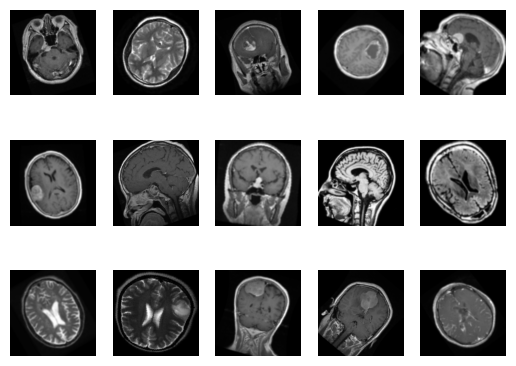

In [ ]:
train_loader, val_loader, test_loader = create_loaders(16)

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')

    k += 1
    if k > 14:
        break